## Building a Sentiment Predicting Model on a Social Media Corpus

### Using the 1.6 Million Tweets Positive/Negative Sentiment Corpus


Helpful Resources:
https://medium.com/@thoszymkowiak/how-to-implement-sentiment-analysis-using-word-embedding-and-convolutional-neural-networks-on-keras-163197aef623

Good Post I found that most of this code is built off of
https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

Corpus (1.6million tweets as positive/negative)
https://drive.google.com/uc?id=0B04GJPshIjmPRnZManQwWEdTZjg&export=download
http://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf





In [1]:
# Standard python helper libraries.
import collections
import itertools
import json
import os
import re
import sys
import time

# Numerical manipulation libraries.
import numpy as np
import pandas as pd
from scipy import stats
import scipy.optimize

# NLTK
import nltk
from nltk.tokenize import word_tokenize

# Helper libraries (from w266 Materials).
# import segment
#from shared_lib import utils
from shared_lib import vocabulary

# Machine Learning Packages
from sklearn.model_selection import train_test_split

# Word2Vec Model
import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
# Pull in Tweet Data (Must be downloaded using https://github.com/seirasto/twitter_download)

# tweets

cols = ['TweetID', 'Sentiment', 'SentimentText']
tweets = pd.read_table("Data/twitter_download-master/ALL_SEMEVAL_TRAIN_DATA.txt", header=None,
                       names=cols, encoding='ISO-8859-1', error_bad_lines=False)
# num_tweets = 1000000
# tweets = pd.read_csv('Data/milliontweetCorpus/training.1600000.processed.noemoticon.csv', 
#                      header=None, names=cols, encoding='ISO-8859-1', error_bad_lines=False) #, nrows=num_tweets)
tweets.drop(['TweetID'], axis=1, inplace=True)
tweets = tweets[tweets.Sentiment.isnull() == False]
tweets['Sentiment'] = tweets['Sentiment'].map({'negative':0, 'neutral':2, 'positive':4})

cols2 = ['Sentiment', 'ItemID', 'DateTime', 'Query', 'SentimentSource', 'SentimentText']
tweets2 = pd.read_csv('Data/milliontweetCorpus/training.1600000.processed.noemoticon.csv', 
                     header=None, names=cols2, encoding='ISO-8859-1', error_bad_lines=False) #, nrows=num_tweets)
tweets2.drop(['ItemID', 'DateTime', 'Query', 'SentimentSource'], axis=1, inplace=True)
tweets2 = tweets2[tweets2.Sentiment.isnull() == False]
tweets2['Sentiment'] = tweets2['Sentiment'].map(int)

tweets = pd.concat([tweets,tweets2], axis=0)

tweets = tweets[tweets['SentimentText'].isnull() == False]
tweets.reset_index(inplace=True)
tweets.drop('index', axis=1, inplace=True)
print('dataset loaded with shape', tweets.shape)
tweets = tweets[tweets['SentimentText'] != 'Not Available']
tweets[tweets['Sentiment'] == 0].head(5)
# SemEval Dataset is actually relatively small (6000 tweets in 2016). 
# We can group all of the Train/Test/Dev data from 2013 through 2016 to get more.
# Additionally, we could consider using this data which has 1.6 million rows but it is only a binary positive/negative class 
# https://drive.google.com/uc?id=0B04GJPshIjmPRnZManQwWEdTZjg&export=download

dataset loaded with shape (1621665, 2)


,Sentiment,SentimentText
0,0,dear @Microsoft the newOoffice for Mac is grea...
1,0,@Microsoft how about you make a system that do...
6,0,@MikeWolf1980 @Microsoft I will be downgrading...
7,0,@Microsoft 2nd computer with same error!!! #Wi...
9,0,"After attempting a reinstall, it still bricks,..."


In [3]:
# Print first 5 Negative Tweets (encoded as 0's)
for i,text in enumerate(tweets[tweets['Sentiment'] == 0]['SentimentText']):
    print('Negative Tweet:', text)
    if i >= 50:
        break
        
# Print first 5 Positive Tweets (encoded as 4's)
for i,text in enumerate(tweets[tweets['Sentiment'] == 4]['SentimentText']):
    print('Positive Tweet:', text)
    if i >= 14:
        break

Negative Tweet: dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.
Negative Tweet: @Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!
Negative Tweet: @MikeWolf1980 @Microsoft I will be downgrading and let #Windows10 be out for almost the 1st yr b4 trying it again. #Windows10fail
Negative Tweet: @Microsoft 2nd computer with same error!!! #Windows10fail Guess we will shelve this until SP1! http://t.co/QCcHlKuy8Q
Negative Tweet: After attempting a reinstall, it still bricks, says, "Windows cannot finish installing," or somesuch. @Microsoft may have cost me $600.
Negative Tweet: Did @Microsoft break Windows 10? Was working fine on Wednesday but now I can't get passed the login screen without it freezing up.
Negative Tweet: For the 1st time @Skype has a "High Startup impact"   Does anyone at @Microsoft have a clue? #Windows10Fail http://t.co/loO3yd5rwe
Negative Tweet: #teen

### Cleaning

Good idea on using the tokenizer.  we can use this as a function with df.apply to speed this up! Check out the stack overflow solution below for some inspiration.  Some exploratory code is below

https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame

In [4]:
from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
t = TweetTokenizer()


def create_tokens(tweet):
    tweet = str(tweet.lower())
    tokens = t.tokenize(tweet)
    tokens = list(filter(lambda x: not x.startswith('@'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('#'), tokens)) ##
    tokens = list(filter(lambda x: not x.startswith('http'), tokens)) ##
    return tokens

tweets['SentimentTextTokenized'] = tweets['SentimentText'].apply(create_tokens)
tweets.head()


X = tweets.SentimentTextTokenized
Y = tweets.Sentiment

### Exploration

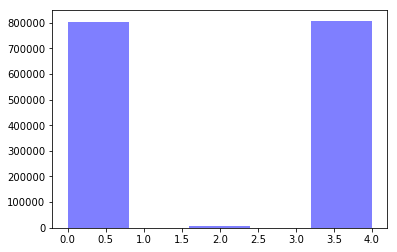

In [5]:

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
 
num_bins = 5
n, bins, patches = plt.hist(tweets.Sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Looks like there are only two categories in this Training Dataset. Negative = 0, Positive = 4

### Preprocessing & (future) Feature Engineering

### Split Train and Test Sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=100)
print(X_train[:10])
print(y_train[:10])

1423397    [just, did, a, test, drive, with, the, bmw, 11...
1595566    [good, luck, lauren, ., i, know, you, are, goi...
1431862    [shipley's, donuts, sounds, amazing, right, no...
716158     [i, dont, like, it, at, all, ., its, confusing...
1581706                          [i, got, it, ..., hehehehe]
59613                    [sorry, to, hear, about, your, dog]
7657       [no, someone, on, the, phone, when, we, report...
979271     [ok, ., done, with, meals, and, all, hangi, ki...
89987      [well, there, goes, my, banner, right, down, t...
1402181    [and, we, love, you, haha, come, back, to, aus...
Name: SentimentTextTokenized, dtype: object
1423397    4
1595566    4
1431862    4
716158     0
1581706    4
59613      0
7657       2
979271     4
89987      0
1402181    4
Name: Sentiment, dtype: int64


### Word2Vec

In [7]:
# Convert each word into a vector representation. Couldn't get Keras working with straight indexes for each word so I followed the steps laid out here:
# https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

vec_dim = 100

tweet_w2v = Word2Vec(size=vec_dim, min_count=5) #vector size and minimum threshold to include for rare words
tweet_w2v.build_vocab(x for x in X_train)
tweet_w2v.train((x for x in X_train), total_examples=tweet_w2v.corpus_count, epochs=1)

14002210

In [8]:
tweet_w2v.most_similar('good')

[('great', 0.7805217504501343),
 ('nice', 0.6860557794570923),
 ('bad', 0.6596325039863586),
 ('cool', 0.6542390584945679),
 ('fantastic', 0.640545129776001),
 ('tough', 0.6350492835044861),
 ('weird', 0.625077486038208),
 ('terrible', 0.6227144002914429),
 ('rough', 0.6202049851417542),
 ('g0od', 0.619382381439209)]

### Create Word Vectors 
https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 31437


In [10]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [11]:
from sklearn.preprocessing import StandardScaler

train_vecs_w2v = np.concatenate([buildWordVector(z, vec_dim) for z in map(lambda x: x, X_train)])

scaler = StandardScaler()
scaler.fit(train_vecs_w2v)
train_vecs_w2v = scaler.transform(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, vec_dim) for z in map(lambda x: x, X_test)])
test_vecs_w2v = scaler.transform(test_vecs_w2v)

In [12]:
# This section only needed if doing more than binary classification (multi-class)
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

print("Original Y:", y_train[:10])
encoder = LabelEncoder()
encoder.fit(Y)
y_train = encoder.transform(y_train)
y_test= encoder.transform(y_test)
print("Encoded Y:", y_train[:10])

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print("One Hot Y:", y_train[:100])

Original Y: 1423397    4
1595566    4
1431862    4
716158     0
1581706    4
59613      0
7657       2
979271     4
89987      0
1402181    4
Name: Sentiment, dtype: int64
Encoded Y: [2 2 2 0 2 0 1 2 0 2]
One Hot Y: [[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0

### CNN Model (really simple)

In [17]:
# Pad the sequence to the same length (this hurt accuracy?)
# train_vecs_w2v = sequence.pad_sequences(train_vecs_w2v, maxlen=vec_dim)
# test_vecs_w2v = sequence.pad_sequences(test_vecs_w2v, maxlen=vec_dim)

# Build Keras Model

# # assemble the embedding_weights in one numpy array
# # vocab_dim = 300 # dimensionality of your word vectors
# n_symbols = len(index_dict) + 1 # adding 1 to account for 0th index (for masking)
# embedding_weights = np.zeros((n_symbols, vocab_dim))
# for word,index in index_dict.items():
#     embedding_weights[index, :] = word_vectors[word]

# # define inputs here
# embedding_layer = Embedding(output_dim=vocab_dim, input_dim=n_symbols, trainable=True)
# embedding_layer.build((None,)) # if you don't do this, the next step won't work
# embedding_layer.set_weights([embedding_weights])

# embedded = embedding_layer(input_layer)

# max_review_length = 30
# X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
# X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

model = Sequential()
model.add(Embedding(len(tfidf), vec_dim))
model.add(Conv1D(32, 3, padding='same'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax')) # softmax if multi-class

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', # categorical_crossentropy if multi-class
              metrics=['accuracy'])

# model.add(Embedding(top_words, vec_dim, input_length=max_review_length))
# model.add(Conv1D(64, 3, padding='same'))
# model.add(Conv1D(32, 3, border_mode='same'))
# model.add(Conv1D(16, 3, border_mode='same'))
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(180,activation='sigmoid'))
# model.add(Dropout(0.2))
# model.add(Dense(1,activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train, epochs=9, batch_size=32, verbose=2)

ValueError: Error when checking target: expected dense_8 to have 3 dimensions, but got array with shape (1293333, 3)

In [ ]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print("Accuracy: %.2f%%" % (score[1]*100))

# Applied to Reddit

In [ ]:
# Function to Predict Positive/Neutral/Negative

def prediction(text):
    sentiment = ["Negative",'Neutral', "Positive"]
    tokens = create_tokens(text)
    vecs = buildWordVector(tokens, vec_dim)
    vecs = scaler.transform(vecs)
    predic = model.predict(vecs)
    result = sentiment[predic.argmax(axis=1)[0]]
    return result

In [ ]:
import praw

#this is a read-only instance
reddit = praw.Reddit(user_agent='first_scrape (by /u/dswald)',
                     client_id='TyAK1zSuAvQjmA', 
                     client_secret="uxHGsL0zNODbowN6umVnBWpqLAQ")

subreddit = reddit.subreddit('tensorflow')
hot_python = subreddit.hot(limit = 3) #need to view >2 to get past promoted posts

for submission in hot_python:
    if not submission.stickied: #top 2 are promoted posts, labeled as 'stickied'
        print('Title: {}, ups: {}, downs: {}, Have we visited: {}'.format(submission.title,
                                                                          submission.ups,
                                                                          submission.downs,
                                                                          submission.visited))
        comments = submission.comments.list() #unstructured
        for comment in comments:
            print (20*'-')
            print ('Parent ID:', comment.parent())
            print ('Comment ID:', comment.id)
            print (comment.body)
            print("#"*10,'PREDICTED SENTIMENT:', prediction(comment.body),"#"*10)

It seems that everythng is positive or neutral.  Is this because of a unigram model or too specific training data or what?  This is food for thought.  Committing now.